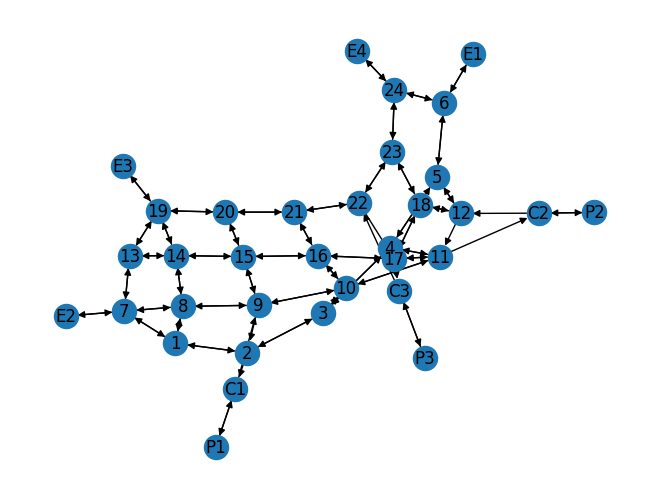

In [43]:
import networkx as nx

G = nx.DiGraph()

def bgc_layout():
    intersection_nodes = {
        #ENTRY NODES
        'E1': (600, 80), 
        'E2': (50, 50), 
        'E3': (100, 500),
        'E4': (650, 500),
        #PARKING NODES
        'P1': (150, 125),
        'P2': (450, 200),
        'P3': (350, 375),
        # CONNECTOR NODES (these are used to connect to parking nodes)
        'C1': (200, 125),
        'C2': (450, 150),
        'C3': (400, 375),
        #PROPER NODES
        # 1st BGC parallel nodes
        1: (100, 100),
        2: (200, 100),
        3: (300, 100),
        4: (400, 100),
        5: (500, 100),
        6: (600, 125),
        # 2nd Parallel nodes
        7: (50, 200),
        8: (100, 200),
        9: (200, 150),
        10: (300, 150),
        11: (400, 150),
        12: (500, 150),
        # 3rd Parallel Nodes
        13: (50, 300),
        14: (100, 300),
        15: (200, 350),
        16: (300, 350),
        17: (400, 350),
        18: (500, 350),
        # 4th Parallel Nodes
        19: (100, 400),
        20: (200, 400),
        21: (300, 400),
        22: (400, 400),
        23: (500, 400),
        24: (600, 375)
    }

    #('E2', 1)
    edge_list = [
        # Important: Current rules for placing edges.
        # 1. For Entry (E) nodes, they must be placed first for each of the tuples
        # 2. For Parking (P) nodes, they must be placed first for each of the tuples
        # 3. //TODO something about connectors only connected to one direction
        #Entry nodesz
        ('E1', 6),('E2', 7),('E3', 19),('E4', 24),
        #Parking and connector nodes,
        ('P1', 'C1'), (2, 'C1') , ('C1', 9),
        ('P2', 'C2'), (11, 'C2') , ('C2', 12),
        ('P3', 'C3'), (17, 'C3'), ('C3', 22),
        #Proper nodes
        (1, 2),(1, 8),(1, 7),
        (2, 1),(2, 3),# (2, 9),
        (3, 2),(3, 4),(3, 10),
        (4, 3),(4, 5),(4, 11),
        (5, 4),(5, 6),(5, 12),
        (6, 5),(6, 24),
        (7, 1),(7, 8),(7, 13),
        (8, 1),(8, 7),(8, 9),(8, 14),
        (9, 2),(9, 8),(9, 10),(9, 15),
        (10, 3),(10, 9),(10, 11),(10, 16),
        (11, 4),(11, 10),(11, 17), #(11, 12),
        (12, 5),(12, 11),(12, 18),
        (13, 7),(13, 14),(13, 19),
        (14, 8),(14, 13),(14, 15),(14, 19),
        (15, 9),(15, 14),(15, 16),(15, 20),
        (16, 10),(16, 15),(16, 17),(16, 21),
        (17, 11),(17, 16),(17, 18), #(17, 22),
        (18, 12),(18, 17),(18, 23),
        (19, 13),(19, 14),(19, 20),
        (20, 15),(20, 19),(20, 21),
        (21, 16),(21, 20),(21, 22),
        (22, 17),(22, 21),(22, 23),
        (23, 18),(23, 22),(23, 24),
        (24, 6),(24, 23)
    ]

    return intersection_nodes, edge_list

intersection_nodes, edge_list = bgc_layout()

entry_nodes = []
entry_edges = []
self_edges = {}

self_edges = {i: {'cars_occupied': [], 'weight': 0} for i in edge_list}

for index, pos in intersection_nodes.items():
    # Add index to the list of entries in the entry_nodes list.
    if "E" in str(index) or "P" in str(index):
        entry_nodes.append(index)
    G.add_node(index, pos=pos)

# Add edges to the graph.
for edges in edge_list:
    # Add edges to the entry edges list
    G.add_edge(edges[0], edges[1])
    if any("E" in str(edge) for edge in edges):
        #for now we will assume that the entry edge is at the first element
        entry_edges.append(edges)

        #add the inverse edge of the E's as well
        self_edges[(edges[1], edges[0])] = {'cars_occupied': [], 'weight': 0}
        G.add_edge(edges[1], edges[0])
    elif any("P" in str(edge) for edge in edges):
        if "P" in str(edges[0]): #this one is more likely to happen for now
            entry_edges.append((edges[0], edges[1]))

            #add the inverse edge of the P's as well
            self_edges[(edges[1], edges[0])] = {'cars_occupied': [], 'weight': 0}
            G.add_edge(edges[1], edges[0])

nx.draw(G, with_labels=True)

In [61]:
# Testing subsequence function
disallowed_sequences = {
    ('C3', 22, 17): 17,
    ('C1', 9, 2): 2,
    ('C2', 12, 11): 11,
}

sample_path = ['P3', 'C3', 22, 17, 11, 'C2', 'P2']

def check_subsequence(paths):
    paths_to_check = paths.copy()
    for sequence, node_to_remove in disallowed_sequences.items():
        sequence = list(sequence)
        print(sequence)
        n = len(sequence)
        for i in range(len(paths_to_check)):
            if paths[i:i+n] == sequence:
                return True, node_to_remove
        return False, None
    
origin_node = 'P3'
next_destination_node = None
final_destination_node = 'P2'

def compute_shortest_path():
    global next_destination_node
    """
    Compute the car agent's shortest path using NetworkX's shortest_path function (default: Djikstra)
    """        
    # edge_weight = tm.get_edge_weight(self.origin_node, self.final_destination_node)
    # paths = nx.shortest_path(tm.G, self.origin_node, self.final_destination_node, weight='weight')
    paths = nx.dijkstra_path(G, origin_node, final_destination_node, weight='weight')
    print(f"Paths {paths}")

    is_illegal_path, node_to_remove = check_subsequence(paths)
    if is_illegal_path:
        temp_G = G.copy()
        temp_G.remove_node(node_to_remove)
        paths = nx.dijkstra_path(temp_G, origin_node, final_destination_node, weight='weight')

    # print(f"Car {self.index} from origin: {origin_node} paths: {paths[1:]}")

    node_paths = iter(paths[1:]) #ommitting first index, since it is already the origin
    next_destination_node = next(node_paths)

print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")
compute_shortest_path()
print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")

Origin: P3, Next Destination: None
Paths ['P3', 'C3', 22, 21, 16, 10, 11, 'C2', 'P2']
['C3', 22, 17]
Origin: P3, Next Destination: C3


In [63]:
# Iteration 1
origin_node = next_destination_node
compute_shortest_path()
print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")



Paths ['C3', 22, 21, 16, 10, 11, 'C2', 'P2']
['C3', 22, 17]
Origin: C3, Next Destination: 22


In [64]:
#Iteration 2
origin_node = next_destination_node
compute_shortest_path()
print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")

Paths [22, 21, 16, 10, 11, 'C2', 'P2']
['C3', 22, 17]
Origin: 22, Next Destination: 21


In [65]:
#Iteration 3
origin_node = next_destination_node
compute_shortest_path()
print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")

Paths [21, 16, 10, 11, 'C2', 'P2']
['C3', 22, 17]
Origin: 21, Next Destination: 16
